Source: https://product-data-science.datamasked.com/courses/496549/lectures/9194609

## Goal

Optimizing marketing campaigns is one of the most common data science tasks. Among the many possible marketing tools, one of the most efficient is emails.

Emails are great because they are free, scalable, and can be easily personalized. Email optimization involves personalizing the text and/or the subject, who should receive it, when should be sent, etc. Machine Learning excels at this.

## Challenge Description

The marketing team of an e-commerce site has launched an email campaign. This site has email addresses from all the users who created an account in the past.

They have chosen a random sample of users and emailed them. The email lets the user know about a new feature implemented on the site. From the marketing team perspective, success is if the user clicks on the link inside of the email. This link takes the user to the company site.

You are in charge of figuring out how the email campaign performed and were asked the following questions:

1. What percentage of users opened the email and what percentage clicked on the link within the email?

2. The VP of marketing thinks that it is stupid to send emails in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email?

3. By how much do you think your model would improve click through rate (defined as # of users who click on the link/total users who receive the email). How would you test that?

4. Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

## Data

In [41]:
import pandas as pd
import numpy as np

email_table = pd.read_csv('data/email/email_table.csv')
email_open = pd.read_csv('data/email/email_opened_table.csv')
link_click = pd.read_csv('data/email/link_clicked_table.csv')

In [42]:
email_table.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [43]:
email_open.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [44]:
link_click.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [45]:
email_open['email_open'] = [1] * len(email_open)
link_click['link_click'] = [1] * len(link_click)

# merge the 3 dataframes
df = email_table.merge(email_open, how='left', on='email_id')
df = df.merge(link_click, how='left', on='email_id')

# mark open the email as 1, not open as 0
# mark click the email as 1, not click as 0
df['email_open'] = df['email_open'].fillna(0)
df['link_click'] = df['link_click'].fillna(0)
df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0


In [46]:
# check for anomaly
df.describe(include='all')

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
count,100000.000000,100000,100000,100000.000000,100000,100000,100000.00000,100000.000000,100000.000000
unique,NaN,2,2,NaN,7,4,NaN,NaN,NaN
top,NaN,long_email,generic,NaN,Saturday,US,NaN,NaN,NaN
freq,NaN,50276,50209,NaN,14569,60099,NaN,NaN,NaN
mean,498690.196160,NaN,NaN,9.059300,NaN,NaN,3.87845,0.103450,0.021190
std,289230.727534,NaN,NaN,4.439637,NaN,NaN,3.19611,0.304547,0.144018
min,8.000000,NaN,NaN,1.000000,NaN,NaN,0.00000,0.000000,0.000000
25%,246708.250000,NaN,NaN,6.000000,NaN,NaN,1.00000,0.000000,0.000000
50%,498447.000000,NaN,NaN,9.000000,NaN,NaN,3.00000,0.000000,0.000000
75%,749942.750000,NaN,NaN,12.000000,NaN,NaN,6.00000,0.000000,0.000000


In [47]:
# check if any email_open as 0 but link_click as 1
df_anomaly = df[(df['email_open']==0)&(df['link_click']==1)]
len(df_anomaly)

50

We assume customers should open the email first, then click the link. So 50 out of 100k data are anomalies, since it's a small portion, and we have no other method the verify whether open the email or not, so these data are not reliable, for accuracy purpose, let's drop them

In [48]:
df['email_id'].nunique()

100000

'email_id' is unique, so we drop the anomaly according to the email_id

In [49]:
df = df[~df['email_id'].isin(df_anomaly['email_id'])].reset_index(drop=True)
df

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0
...,...,...,...,...,...,...,...,...,...
99945,803504,short_email,personalized,4,Monday,US,5,0.0,0.0
99946,899722,long_email,personalized,7,Saturday,US,1,0.0,0.0
99947,449610,long_email,personalized,11,Saturday,UK,6,0.0,0.0
99948,72497,short_email,generic,10,Monday,UK,0,0.0,0.0


### Question 1

In [50]:
print('{:.1%} of users opened the email'.format(df['email_open'].mean()))
print('{:.1%} of users clicked the link'.format(df['link_click'].mean()))

10.4% of users opened the email
2.1% of users clicked the link


###  Question 4

how email campaign performed for different segments of users

#### Data exploration

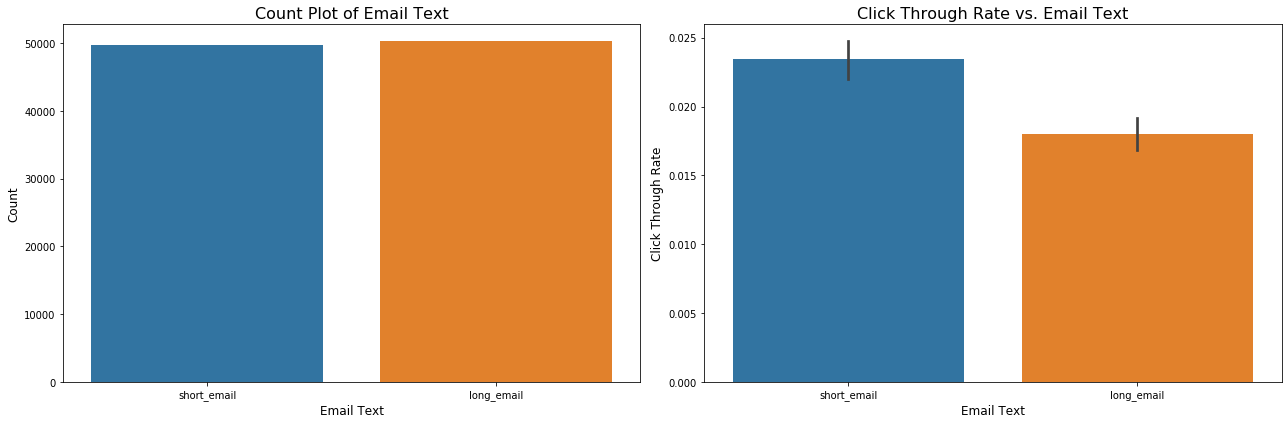

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# visualize email_text
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_text', data=df, ax=ax[0])
ax[0].set_xlabel('Email Text', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Text', fontsize=16)

sns.barplot(x='email_text', y='link_click', data=df, ax=ax[1])
ax[1].set_xlabel('Email Text', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Text', fontsize=16)

plt.tight_layout()
plt.show()

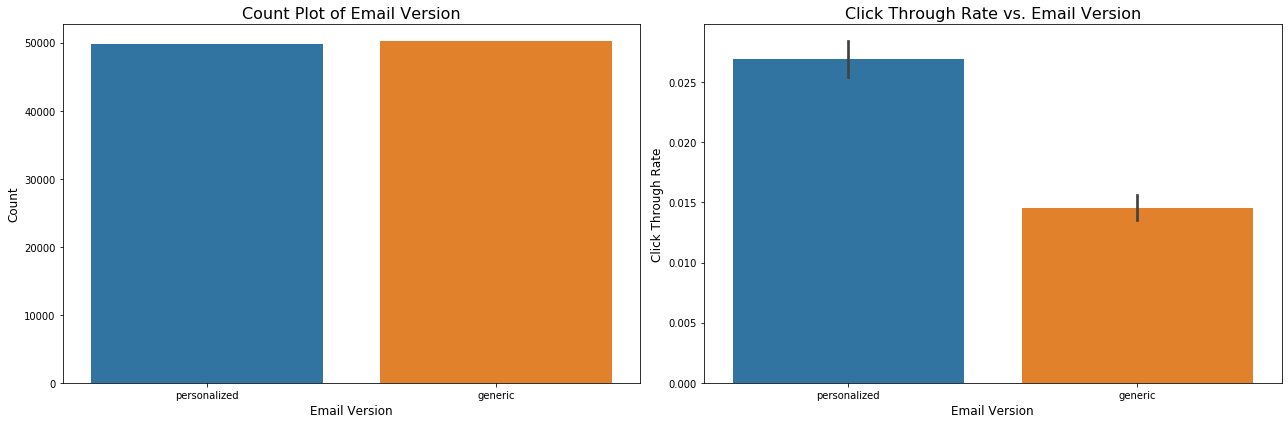

In [65]:
# visualize email_version
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_version', data=df, ax=ax[0])
ax[0].set_xlabel('Email Version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Version', fontsize=16)

sns.barplot(x='email_version', y='link_click', data=df, ax=ax[1])
ax[1].set_xlabel('Email Version', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Version', fontsize=16)

plt.tight_layout()
plt.show()

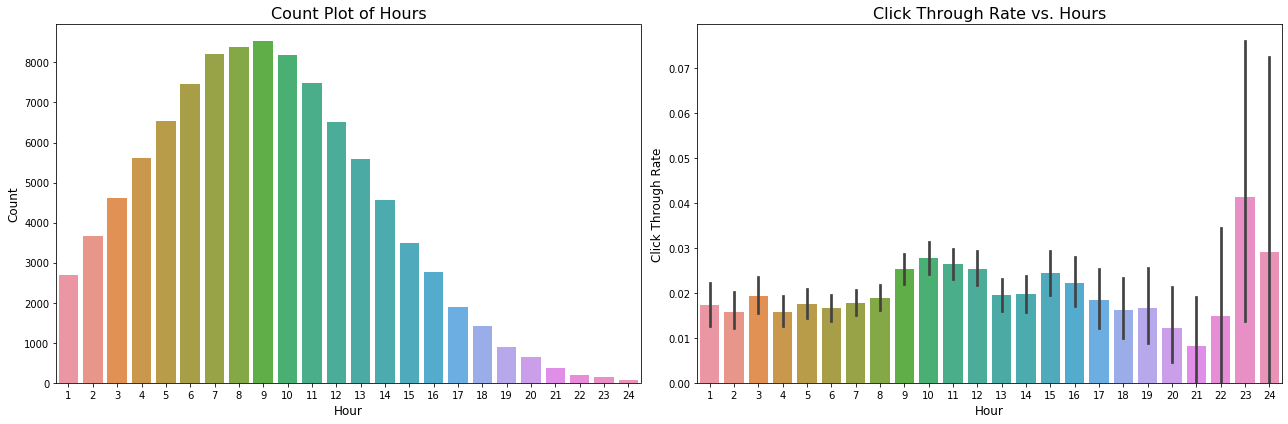

In [66]:
# visualize hour
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=df, ax=ax[0])
ax[0].set_xlabel('Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Hours', fontsize=16)

sns.barplot(x='hour', y='link_click', data=df, ax=ax[1])
ax[1].set_xlabel('Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Hours', fontsize=16)

plt.tight_layout()
plt.show()

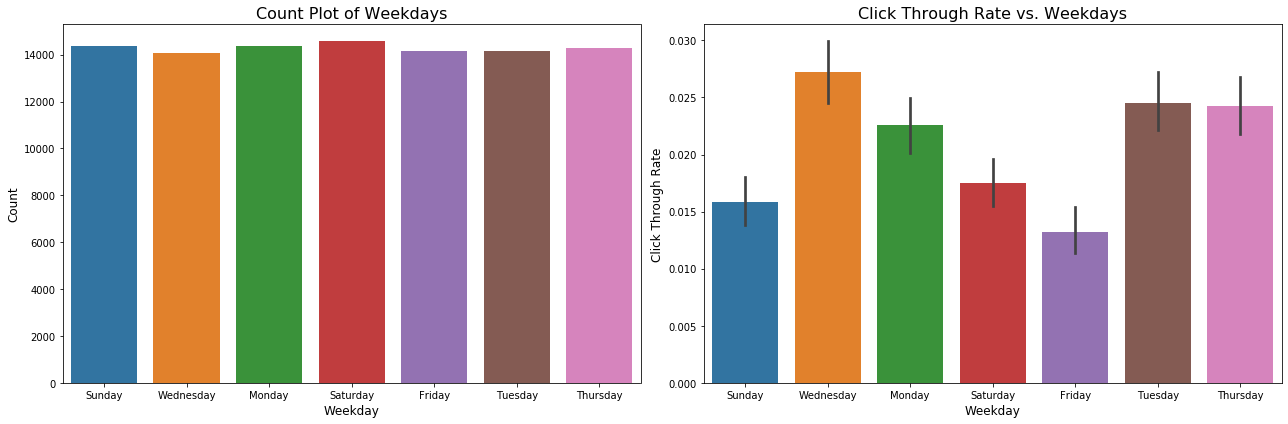

In [67]:
# visualize weekday
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='weekday', data=df, ax=ax[0])
ax[0].set_xlabel('Weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Weekdays', fontsize=16)

sns.barplot(x='weekday', y='link_click', data=df, ax=ax[1])
ax[1].set_xlabel('Weekday', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Weekdays', fontsize=16)

plt.tight_layout()
plt.show()

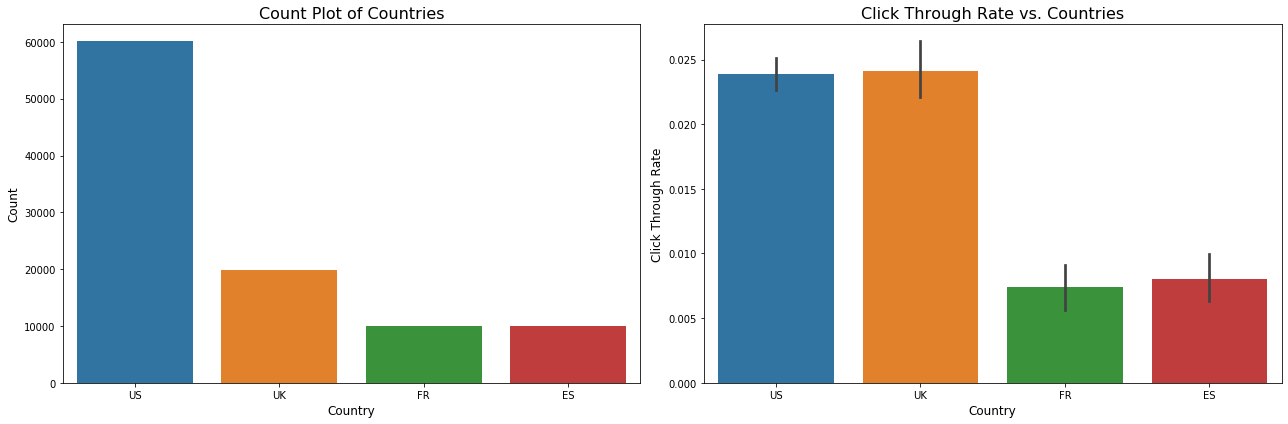

In [68]:
# visualize user country
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_country', data=df, ax=ax[0])
ax[0].set_xlabel('Country', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Countries', fontsize=16)

sns.barplot(x='user_country', y='link_click', data=df, ax=ax[1])
ax[1].set_xlabel('Country', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Countries', fontsize=16)

plt.tight_layout()
plt.show()

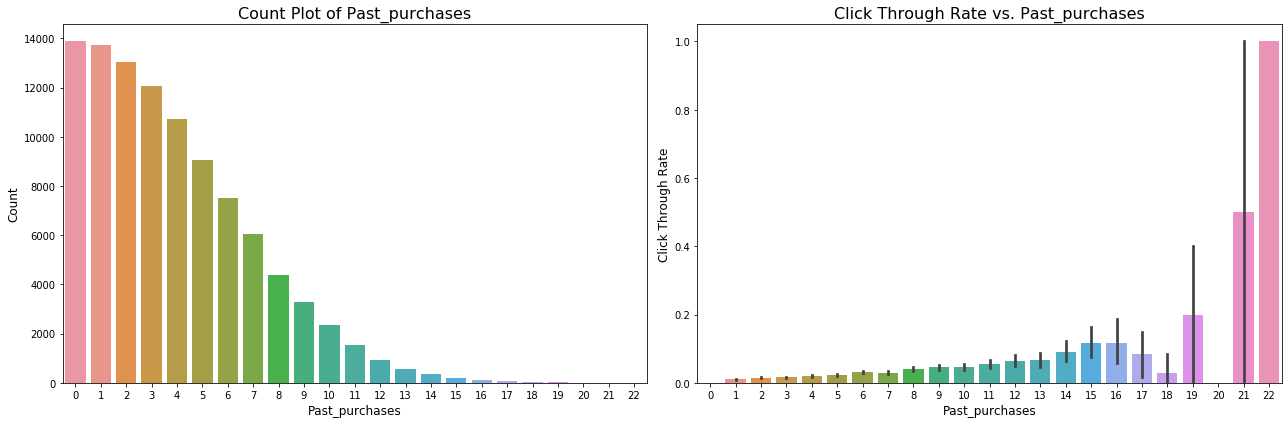

In [70]:
# visualize user country
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_past_purchases', data=df, ax=ax[0])
ax[0].set_xlabel('Past_purchases', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Past_purchases', fontsize=16)

sns.barplot(x='user_past_purchases', y='link_click', data=df, ax=ax[1])
ax[1].set_xlabel('Past_purchases', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Past_purchases', fontsize=16)

plt.tight_layout()
plt.show()

Conclusion: tips for improving the click-trough-rate(CTR) in email campaign
1. email should be short and personalized
2. Better to send out emails in 9am-12pm, 3pm-5pm, and 10pm-12am
3. Better to send out emails on Mondays, Tuesdays, Wednesdays, and Thursday. Fridays tend to have the lowest CTR.
4. Customers in US and UK have higher CTR
5. Users with 14-17 or 19-22 past purchases have higher CTR (customer retention)

### Question 2

build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email

#### Data preprocessing and feature extracting

In [11]:
# convert weekdays from categories to numerical variable
dic = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6}
df['weekday'].replace(dic, inplace=True)
df['weekday'].unique()

array([0, 3, 1, 6, 5, 2, 4])

In [71]:
# drop some useless cols, 'email_open' has high correlation to link_click
df = df.drop(['email_id', 'email_open'], axis=1)
# get dummies
df = pd.get_dummies(df, drop_first=True)
df

,hour,user_past_purchases,link_click,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US
0,2,5,0.0,1,1,0,0,1,0,0,0,0,0,1
1,12,2,1.0,0,1,0,0,1,0,0,0,0,1,0
2,11,2,0.0,0,1,0,0,0,0,0,1,0,0,1
3,6,1,0.0,1,0,1,0,0,0,0,0,0,1,0
4,14,6,0.0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99945,4,5,0.0,1,1,1,0,0,0,0,0,0,0,1
99946,7,1,0.0,0,1,0,1,0,0,0,0,0,0,1
99947,11,6,0.0,0,1,0,1,0,0,0,0,0,1,0
99948,10,0,0.0,1,0,1,0,0,0,0,0,0,1,0


In [72]:
df.groupby(['link_click'])['link_click'].count()

link_click
0.0    97881
1.0     2069
Name: link_click, dtype: int64

Very unbalanced data, only 2.1% positive sample

#### train, test split and model build

In [101]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, classification_report

# train, test split, make sure each contains same % of positive class
df_p = df[df['link_click'] == 1]
df_n = df[df['link_click'] == 0].sample(frac=0.07) # undersample negatives to improve balance

train_p, test_p = train_test_split(df_p, test_size=0.35)
train_n, test_n = train_test_split(df_n, test_size=0.35)

# concat train and test set, and shuffle the dataframe
train = pd.concat([train_p, train_n]).sample(frac=1)
test = pd.concat([test_p, test_n]).sample(frac=1)

In [102]:
# build the model
train_x = train.drop('link_click', axis=1)
train_y = train['link_click']

rf = RandomForestClassifier(class_weight='balanced', oob_score=True)
rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [103]:
y_train_pred = rf.oob_decision_function_[:,1].round() # the pred for class 1 is either 1 or 0

#let's print OOB accuracy and confusion matrix
print(
"OOB training accuracy is", 
rf.oob_score_, 
"\n", 
"OOB training Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train_y, y_train_pred, labels=[0, 1])))

OOB training accuracy is 0.7231326548214594 
 OOB training Confusion Matrix 
       0    1
0  3759  694
1   911  433


In [104]:
test_x = test.drop('link_click', axis=1)
test_y = test['link_click']
y_test_pred = rf.predict(test_x)

print(
'OOB test accuracy is', rf.score(test_x, test_y),
'\n',
'OOB test Confusion Matrix',
'\n',
pd.DataFrame(confusion_matrix(test_y, y_test_pred, labels=[0,1])))

OOB test accuracy is 0.7115877080665813 
 OOB test Confusion Matrix 
       0    1
0  2006  393
1   508  217


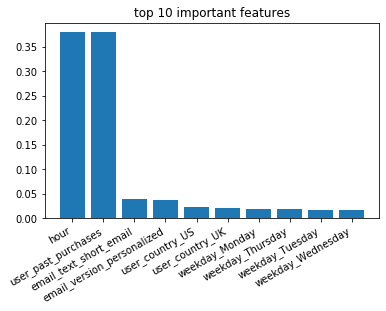

In [105]:
from heapq import nlargest
import matplotlib.pyplot as plt

# get the top 10 important features in rf
features = test_x.columns.to_list()
dic = {}
for i in range(len(features)):
    dic[features[i]] = rf.feature_importances_[i]

features_10 = nlargest(10, dic, key = dic.get) 
importances_10 = []
for f in features_10:
    importances_10.append(dic[f])

# plot
fig, ax = plt.subplots()
ax.bar(features_10, importances_10)
ax.set_title('top 10 important features')
fig.autofmt_xdate()
plt.show()

In [126]:
y_train_prob = rf.oob_decision_function_[:,1].round()
y_test_prob = rf.predict_proba(test_x)[:,1]

train_fpr, train_tpr, train_thresholds = roc_curve(train_y, y_train_prob)
test_fpr, test_tpr, test_thresholds = roc_curve(test_y, y_test_prob)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

# Classification report
print(classification_report(y_true=test_y, y_pred=(y_test_prob > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82      2399
         1.0       0.36      0.30      0.33       725

    accuracy                           0.71      3124
   macro avg       0.58      0.57      0.57      3124
weighted avg       0.70      0.71      0.70      3124



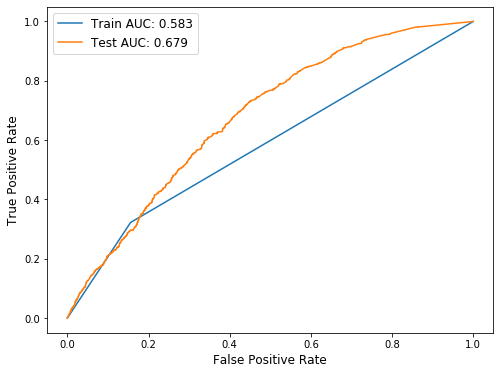

In [125]:
# ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [127]:
# maximize TPR of testing

# class0_error = fpr
# class1_error = 1 - tpr

error_cutoff = pd.DataFrame({'cutoff':pd.Series(test_thresholds),
                               'class0_error':pd.Series(test_fpr),
                               'class1_error': 1 - pd.Series(test_tpr)
                                })

error_cutoff['optimal_value'] = 1 - error_cutoff['class0_error'] - error_cutoff['class1_error'] # = tpr - fpr

error_cutoff.sort_values('optimal_value', ascending=False).head(1)

,cutoff,class0_error,class1_error,optimal_value
688,0.132332,0.452272,0.266207,0.281521


When cutoff is 0.13, the model can have an optimal combination of fpr and tpr, which are 0.45 and 0.73 respectively.

### Question 3

#### Conclusion

1. This model has an optimal test true positive rate of 0.73, so ideally, if we use it to forecast whether the customer will click the link, and we send out emails to all the predicted class=1, 73% of them will click the link. 
2. However, because the training data samples is very much unbalanced, the model fails to predict true positive, and has a false negative rate of 0.33 (class1 error), so it's probable that it fails to recognize some customers who will click the link, and thus we don't send emails to them.

#### Design an AB testing to test the model

To test it, we can conduct A/B test to see if the built model can actually help improve the click-through-rate.

1. Randomly assign users to two groups, Control group and Experiment group, each group has the same number of users
2. In Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.
3. In Experiment group, use this model to predict whether the user will click the link or not. And only send emails to those users whose predictive result is positive.
4. Preform a one-tail unpaired t-test to test whether Experiement group's CTR mean is higher than Control group's CTR mean.

#### Plot 2-3 trees from the random forest, to understand the classification

In [32]:
# import os
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

# import six
# import pydot
# from sklearn import tree

# dotfile = six.StringIO()
# i_tree = 0
# for tree_in_forest in rf.estimators_:
#     export_graphviz(tree_in_forest,out_file='tree.dot',
#                     feature_names=features,
#                     filled=True,
#                     rounded=True)
#     (graph,) = pydot.graph_from_dot_file('tree.dot')
#     name = 'tree' + str(i_tree)
#     graph.write_png(name+  '.png')
#     os.system('dot -Tpng tree.dot -o tree.png')
#     i_tree +=1

# extract single tree
estimators = rf.estimators_[3:5]

for idx, tree in enumerate(estimators):
    filename = 'EmailCampagin_tree_{}'.format(idx)
    export_graphviz(tree, out_file='{}.dot'.format(filename), 
                    feature_names = features,
    #                 class_names = iris.target_names,
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)
    call(['dot', '-Tpng', '{}.dot'.format(filename), '-o', '{}.png'.format(filename), '-Gdpi=600'])
    Image(filename = '{}.png'.format(filename))


The Random Forest tree is too larget, let's try Decision Tree as model and plot

In [35]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

#we are not too interested in predictive power, we are mainly using the tree as a descriptive stat tool
tree = DecisionTreeClassifier( max_depth=4, min_samples_leaf = 30, 
                              class_weight="balanced", min_impurity_decrease = 0.001)
tree.fit(train_x, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

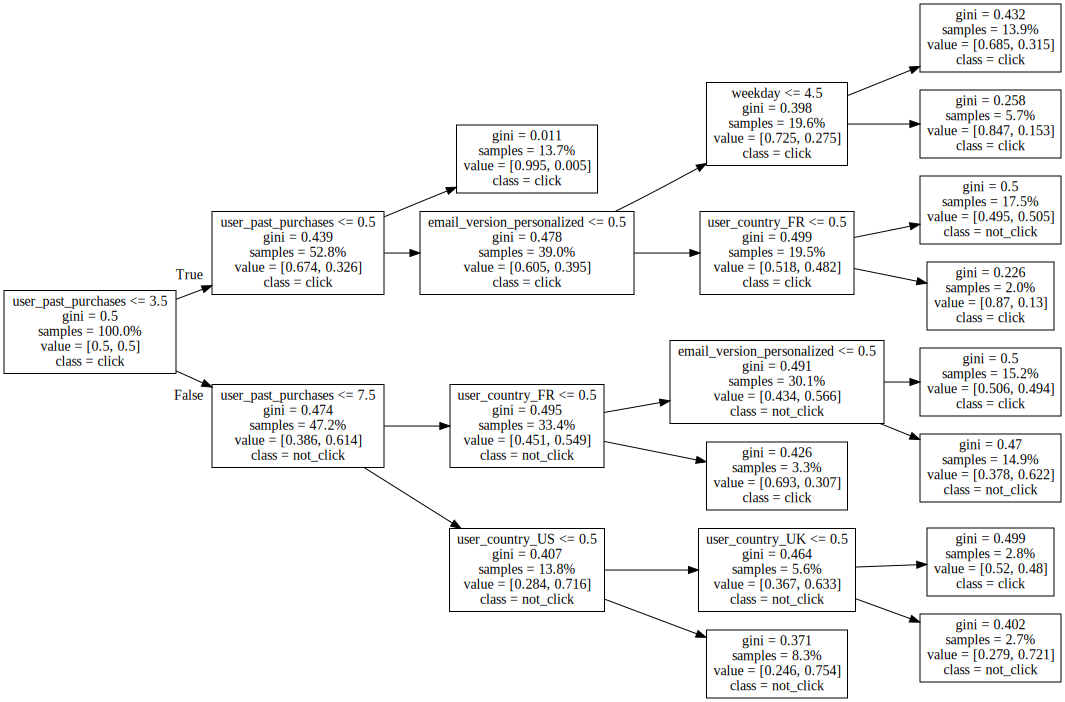

In [38]:
#visualize it
export_graphviz(tree, out_file='EmailCampaign_tree.dot', 
                feature_names=features,
                class_names=['click', 'not_click'],
                proportion=True, rotate=True)

with open('EmailCampaign_tree.dot') as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)